In [2]:
# importing necessary library
import os
import kagglehub
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import copy

In [3]:
# Installing Hugging Face datasets library
%pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [4]:
# Loading the arXiv dataset with article and abstract
from datasets import load_dataset
dataset = load_dataset("scientific_papers", "arxiv", split="train[:1%]")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.27k [00:00<?, ?B/s]

scientific_papers.py:   0%|          | 0.00/5.35k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/203037 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6436 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6440 [00:00<?, ? examples/s]

In [5]:
# Checking structure of the dataset
print(dataset[0].keys())

dict_keys(['article', 'abstract', 'section_names'])


In [6]:
# Training Byte-Level BPE tokenizer from scratch
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
# Creating corpus file from article and abstract
with open("corpus.txt", "w", encoding="utf-8") as f:
    for sample in dataset:
        f.write(sample['article'].replace("\n", " ") + "\n")   # input
        f.write(sample['abstract'].replace("\n", " ") + "\n")  # target/summary
# Initializing and training tokenizer
tokenizer = ByteLevelBPETokenizer()
tokenizer.train(
    files="corpus.txt",
    vocab_size=30522,
    min_frequency=2,
    special_tokens=["<s>", "</s>", "<pad>", "<unk>"]
)
import os
os.makedirs("custom_tokenizer", exist_ok=True)
tokenizer.save_model("custom_tokenizer")
# Loading the trained tokenizer
tokenizer = ByteLevelBPETokenizer(
    "custom_tokenizer/vocab.json",
    "custom_tokenizer/merges.txt"
)
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>"))
)
tokenizer.enable_truncation(max_length=128)

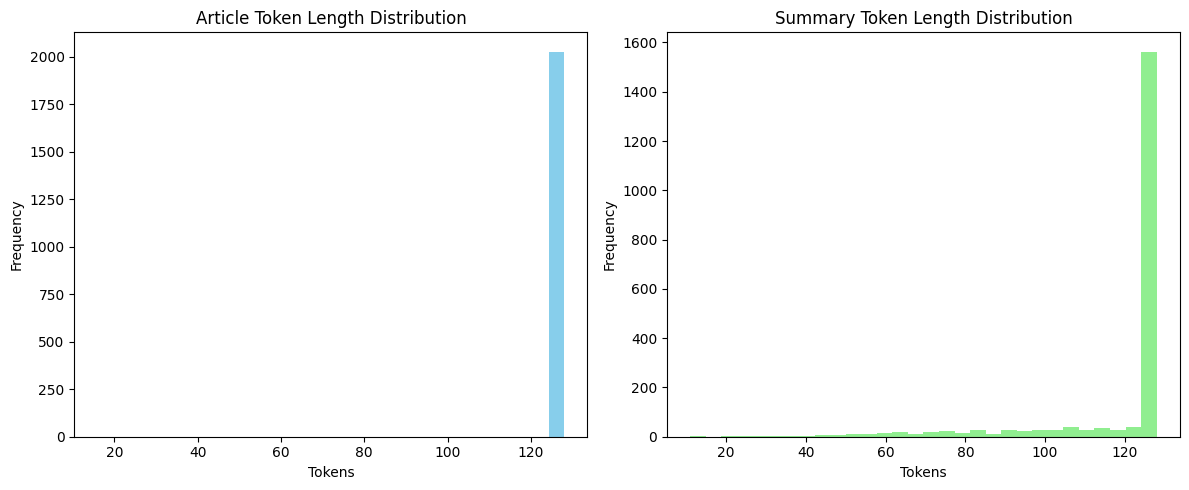

In [7]:
# Plotting token length distribution of articles and summaries
import matplotlib.pyplot as plt
article_lengths = [len(tokenizer.encode(sample["article"]).ids) for sample in dataset]
summary_lengths = [len(tokenizer.encode(sample["abstract"]).ids) for sample in dataset]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(article_lengths, bins=30, color="skyblue")
plt.title("Article Token Length Distribution")
plt.xlabel("Tokens")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(summary_lengths, bins=30, color="lightgreen")
plt.title("Summary Token Length Distribution")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [8]:
# Defining preprocessing to tokenize and pad inputs/targets
def preprocess(example):
    input_ids = tokenizer.encode(example["article"]).ids[:128]
    target_ids = tokenizer.encode(example["abstract"]).ids[:32]

    input_ids += [tokenizer.token_to_id("<pad>")] * (128 - len(input_ids))
    target_ids = [tokenizer.token_to_id("<s>")] + target_ids + [tokenizer.token_to_id("</s>")]
    target_ids += [tokenizer.token_to_id("<pad>")] * (34 - len(target_ids))

    return {"input_ids": input_ids, "labels": target_ids}


In [9]:
# Applying preprocessing function to the dataset
dataset = dataset.map(preprocess)

Map:   0%|          | 0/2030 [00:00<?, ? examples/s]

In [10]:
# Checking keys of processed dataset
print(dataset[0].keys())

dict_keys(['article', 'abstract', 'section_names', 'input_ids', 'labels'])


In [11]:
# Defining helper to clone a module to be used in Transformer
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [12]:
# Defining Positional Encoding for token embeddings
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Creating constant 'pe' matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Adding position info to input embeddings
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [13]:
# Creating Layer Normalization
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
    # Applying normalization
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [14]:
# Creating Sublayer connection block with residual + normalization
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    # Applying residual connection and normalization
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [15]:
# Creating Scaled Dot-Product Attention
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)# getting dimension of key/query
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)# calculating scaled dot-product
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)# applying mask to ignore padding
    p_attn = torch.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)# applying dropout to attention weights
    return torch.matmul(p_attn, value), p_attn

In [16]:
# Creating Multi-Head Attention module
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0# making sure model dimension is divisible by number of heads
        self.d_k = d_model // h# calculating dimension per head
        self.h = h# storing number of heads
        # creating linear layers for query, key, value, and output projection
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)# setting dropout

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)# adjusting mask shape for multi-head
        nbatches = query.size(0)# getting batch size
        # projecting query, key, and value for each head and reshaping
        query, key, value = [
            l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for l, x in zip(self.linears, (query, key, value))
        ]
        # computing attention and getting weighted values
        x, self.attn = attention(query, key, value, mask, self.dropout)
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)# reshaping back and combining heads
        return self.linears[-1](x)

In [17]:
# Creating Feedforward layer used in Transformer
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)# projecting input to higher dimension
        self.w_2 = nn.Linear(d_ff, d_model)# projecting back to original dimension
        self.dropout = nn.Dropout(dropout)# applying dropout between layers
    # Applying two-layer feedforward with ReLU and dropout
    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [18]:
# Creating a single Encoder layer self-attention + feedforward
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn# setting self-attention layer
        self.feed_forward = feed_forward# setting feedforward layer
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
    # Applying self-attention followed by feedforward, with residual connections
    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [19]:
# Creating a single Decoder layer: masked self-attn, encoder-decoder attn, feedforward
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn# setting masked self-attention
        self.src_attn = src_attn# setting encoder-decoder attention
        self.feed_forward = feed_forward# setting feedforward layer
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory# storing encoder output as memory
        # Applying masked self-attention, encoder-decoder attention, then feedforward
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [20]:
# Creating Encoder stack by stacking multiple Encoder layers
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)# cloning the EncoderLayer N times
        self.norm = LayerNorm(layer.size)# applying final normalization

    def forward(self, x, mask):
      # Passing input through each Encoder layer
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)# returning final normalized output
# Creating Decoder stack by stacking multiple Decoder layers
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
      # Passing input through each Decoder layer
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
            # returning final normalized output
        return self.norm(x)

In [21]:
# Creating token embeddings with positional scaling
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)# looking up embedding table
        self.d_model = d_model

    def forward(self, x):
      # Scaling embeddings by sqrt(d_model) to stabilize gradients
        return self.lut(x) * math.sqrt(self.d_model)

In [22]:
# Creating the full Transformer model: Encoder + Decoder + Generator
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder# setting encoder stack
        self.decoder = decoder# setting decoder stack
        self.src_embed = src_embed# embedding + positional encoding for source
        self.tgt_embed = tgt_embed# embedding + positional encoding for target
        self.generator = generator# projection to vocabulary + softmax

    def forward(self, src, tgt, src_mask, tgt_mask):
      # Encoding source, then decoding target based on encoded memory
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
      # Embedding and passing source into encoder
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
      # Embedding and decoding target using encoder memory
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [23]:
# Creating the Generator to convert decoder output to vocabulary prediction
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
      # Applying log softmax to get token probabilities
        return F.log_softmax(self.proj(x), dim=-1)

# Creating a mask to block attention to future positions in the decoder
def subsequent_mask(size):
    attn_shape = (1, size, size)
    mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.uint8)
    return mask == 0

In [24]:
# Building the full Transformer model
def make_model(vocab_size, N=6, d_model=768, d_ff=3072, h=8, dropout=0.2):
  # Creating attention, feedforward, and positional encoding layers
    attn = MultiHeadedAttention(h, d_model)# setting multi-head attention
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)# creating feedforward network
    position = PositionalEncoding(d_model, dropout)# applying positional encoding
    # Constructing the full Encoder-Decoder architecture
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, attn, ff, dropout), N),# stacking N encoder layers
        Decoder(DecoderLayer(d_model, attn, attn, ff, dropout), N),# stacking N decoder layers
        nn.Sequential(Embeddings(d_model, vocab_size), position),# embedding + positional encoding for source
        nn.Sequential(Embeddings(d_model, vocab_size), position),# embedding + positional encoding for target
        Generator(d_model, vocab_size)# output generator projecting to vocab size
    )
    return model

In [25]:
# Creating mask to block future tokens in decoder during training
def subsequent_mask(size):
    # Masking out upper triangular matrix
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.uint8)
    return subsequent_mask == 0

In [26]:
# Importing utilities for dataset handling
from torch.utils.data import Dataset, DataLoader
# Wrapping tokenized HuggingFace dataset into PyTorch Dataset
class ArxivDataset(Dataset):
    def __init__(self, data):
        self.data = data# storing preprocessed dataset

    def __len__(self):
        return len(self.data)# returning dataset length

    def __getitem__(self, idx):
      # Getting tokenized input-output pair
        item = self.data[idx]
        src = torch.tensor(item["input_ids"])# getting source tokens
        tgt = torch.tensor(item["labels"])# getting target summary tokens
        return src, tgt

# Creating DataLoader to load batches during training
dataset = ArxivDataset(dataset)  # converting HuggingFace dataset to PyTorch Dataset
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)# loading data in batches with shuffling

In [27]:
# Function to generate summary from input text using greedy decoding
def generate_summary(model, input_text, tokenizer, max_len=64):
    model.eval()# setting model to evaluation mode

    # Tokenizing the input article
    input_ids = tokenizer.encode(input_text).ids[:128]# trimming to max 128 tokens
    input_ids += [tokenizer.token_to_id("<pad>")] * (128 - len(input_ids))# padding to fixed length
    src = torch.tensor([input_ids]).to(next(model.parameters()).device)# creating batch and moving to device
    src_mask = (src != tokenizer.token_to_id("<pad>")).unsqueeze(-2)# creating source mask

    # Setting start and end token IDs
    start_symbol = tokenizer.token_to_id("<s>")
    eos_symbol = tokenizer.token_to_id("</s>")

    # Decoding output tokens using greedy strategy
    decoded_ids = greedy_decode(model, src, src_mask, max_len, start_symbol, eos_symbol)

    # Removing special tokens and decoding to text
    token_ids = [t for t in decoded_ids[0].tolist() if t not in [
    tokenizer.token_to_id("<pad>"),
    tokenizer.token_to_id("<s>"),
    tokenizer.token_to_id("</s>")]]

    return tokenizer.decode(token_ids)

In [28]:
# Loading original raw dataset for evaluation
from datasets import load_dataset
raw_dataset = load_dataset("scientific_papers", "arxiv", split="train[:1%]")

In [30]:
# Downloading NLTK resources and installing metrics libraries
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [32]:
%pip install rouge_score
%pip install bert_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=74565a042a0893618eca09aee5835bdeab6602132be5261a838dabfce5a15c94
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [35]:
# Importing necessary libraries for training and evaluation
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from bert_score import score as bertscore
from nltk.tokenize import word_tokenize

# Setting the device, GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initializing model, loss, and optimizer
vocab_size = tokenizer.get_vocab_size()
pad_token_id = tokenizer.token_to_id("<pad>")
model = make_model(vocab_size).to(device)# creating and sending model to device
loss_fn = nn.NLLLoss(ignore_index=pad_token_id)# ignoring pad token in loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)# setting learning rate

# Initializing lists to track metrics
epochs = 250
loss_history = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []
bleu_scores = []
bertscore_f1s = []

# Setting up metric helpers
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
smoothie = SmoothingFunction().method4# smoothing for BLEU

# Starting training loop
for epoch in range(epochs):
    model.train()# setting model to training mode
    total_loss = 0
    print(f"\nEpoch {epoch+1}/{epochs}")
    # Iterating through batches
    for src, tgt in tqdm(train_loader):
        src = src.to(device)
        tgt = tgt.to(device)
        # Preparing decoder input and output
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]
        # Creating masks for source and target
        src_mask = (src != pad_token_id).unsqueeze(-2)
        tgt_mask = (tgt_input != pad_token_id).unsqueeze(-2) & subsequent_mask(tgt_input.size(-1)).to(device)
        # Running forward pass
        out = model(src, tgt_input, src_mask, tgt_mask)
        logits = model.generator(out)
        # Reshaping tensors for loss calculation
        logits = logits.view(-1, logits.size(-1))
        tgt_output = tgt_output.contiguous().view(-1)
        # Calculating and updating loss
        loss = loss_fn(logits, tgt_output)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculating average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Avg Loss: {avg_loss:.4f}")

    # Evaluate on 1 sample
    model.eval()
    sample = raw_dataset[0]["article"]
    reference = raw_dataset[0]["abstract"]
    prediction = generate_summary(model, sample, tokenizer)

    # Calculating ROUGE scores
    scores = scorer.score(reference, prediction)
    rouge1_scores.append(scores["rouge1"].fmeasure)
    rouge2_scores.append(scores["rouge2"].fmeasure)
    rougeL_scores.append(scores["rougeL"].fmeasure)

    # Calculating BLEU score
    ref_tokens = word_tokenize(reference)
    pred_tokens = word_tokenize(prediction)
    bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie)
    bleu_scores.append(bleu)

    # Calculating BERTScore
    _, _, f1 = bertscore([prediction], [reference], lang="en", verbose=False)
    bertscore_f1s.append(f1[0].item())

    # Printing all evaluation metrics
    print(f"ROUGE-1: {scores['rouge1'].fmeasure:.4f} | ROUGE-2: {scores['rouge2'].fmeasure:.4f} | ROUGE-L: {scores['rougeL'].fmeasure:.4f}")
    print(f" BLEU: {bleu:.4f} |  BERTScore F1: {f1[0].item():.4f}")


Epoch 1/250


100%|██████████| 254/254 [00:32<00:00,  7.87it/s]


Avg Loss: 6.9553


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0537 | ROUGE-2: 0.0136 | ROUGE-L: 0.0537
 BLEU: 0.0001 |  BERTScore F1: 0.7742

Epoch 2/250


100%|██████████| 254/254 [00:33<00:00,  7.67it/s]


Avg Loss: 5.7141


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0519 | ROUGE-2: 0.0000 | ROUGE-L: 0.0390
 BLEU: 0.0002 |  BERTScore F1: 0.7735

Epoch 3/250


100%|██████████| 254/254 [00:33<00:00,  7.68it/s]


Avg Loss: 5.3528


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0153 | ROUGE-2: 0.0000 | ROUGE-L: 0.0153
 BLEU: 0.0000 |  BERTScore F1: 0.7544

Epoch 4/250


100%|██████████| 254/254 [00:33<00:00,  7.69it/s]


Avg Loss: 5.0822


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0816 | ROUGE-2: 0.0000 | ROUGE-L: 0.0544
 BLEU: 0.0000 |  BERTScore F1: 0.7752

Epoch 5/250


100%|██████████| 254/254 [00:33<00:00,  7.65it/s]


Avg Loss: 4.8451


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1783 | ROUGE-2: 0.0258 | ROUGE-L: 0.1019
 BLEU: 0.0010 |  BERTScore F1: 0.7814

Epoch 6/250


100%|██████████| 254/254 [00:33<00:00,  7.67it/s]


Avg Loss: 4.6370


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0299 | ROUGE-2: 0.0000 | ROUGE-L: 0.0149
 BLEU: 0.0000 |  BERTScore F1: 0.7844

Epoch 7/250


100%|██████████| 254/254 [00:33<00:00,  7.66it/s]


Avg Loss: 4.4444


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0506 | ROUGE-2: 0.0000 | ROUGE-L: 0.0506
 BLEU: 0.0005 |  BERTScore F1: 0.7913

Epoch 8/250


100%|██████████| 254/254 [00:33<00:00,  7.67it/s]


Avg Loss: 4.2708


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0135 | ROUGE-2: 0.0000 | ROUGE-L: 0.0135
 BLEU: 0.0000 |  BERTScore F1: 0.7785

Epoch 9/250


100%|██████████| 254/254 [00:33<00:00,  7.68it/s]


Avg Loss: 4.1016


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0791 | ROUGE-2: 0.0114 | ROUGE-L: 0.0565
 BLEU: 0.0028 |  BERTScore F1: 0.7781

Epoch 10/250


100%|██████████| 254/254 [00:33<00:00,  7.68it/s]


Avg Loss: 3.9476


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0282 | ROUGE-2: 0.0000 | ROUGE-L: 0.0141
 BLEU: 0.0000 |  BERTScore F1: 0.7842

Epoch 11/250


100%|██████████| 254/254 [00:33<00:00,  7.65it/s]


Avg Loss: 3.8019


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0263 | ROUGE-2: 0.0000 | ROUGE-L: 0.0263
 BLEU: 0.0002 |  BERTScore F1: 0.7775

Epoch 12/250


100%|██████████| 254/254 [00:33<00:00,  7.69it/s]


Avg Loss: 3.6662


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.7643

Epoch 13/250


100%|██████████| 254/254 [00:33<00:00,  7.68it/s]


Avg Loss: 3.5396


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0305 | ROUGE-2: 0.0000 | ROUGE-L: 0.0305
 BLEU: 0.0000 |  BERTScore F1: 0.7760

Epoch 14/250


100%|██████████| 254/254 [00:33<00:00,  7.65it/s]


Avg Loss: 3.4251


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0270 | ROUGE-2: 0.0000 | ROUGE-L: 0.0270
 BLEU: 0.0000 |  BERTScore F1: 0.7906

Epoch 15/250


100%|██████████| 254/254 [00:33<00:00,  7.66it/s]


Avg Loss: 3.3155


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0685 | ROUGE-2: 0.0000 | ROUGE-L: 0.0548
 BLEU: 0.0000 |  BERTScore F1: 0.7934

Epoch 16/250


100%|██████████| 254/254 [00:33<00:00,  7.63it/s]


Avg Loss: 3.2100


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0694 | ROUGE-2: 0.0000 | ROUGE-L: 0.0462
 BLEU: 0.0013 |  BERTScore F1: 0.7769

Epoch 17/250


100%|██████████| 254/254 [00:33<00:00,  7.68it/s]


Avg Loss: 3.1074


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0658 | ROUGE-2: 0.0133 | ROUGE-L: 0.0526
 BLEU: 0.0004 |  BERTScore F1: 0.7827

Epoch 18/250


100%|██████████| 254/254 [00:33<00:00,  7.69it/s]


Avg Loss: 3.0093


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0248 | ROUGE-2: 0.0000 | ROUGE-L: 0.0248
 BLEU: 0.0005 |  BERTScore F1: 0.7671

Epoch 19/250


100%|██████████| 254/254 [00:33<00:00,  7.65it/s]


Avg Loss: 2.9139


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0543 | ROUGE-2: 0.0000 | ROUGE-L: 0.0326
 BLEU: 0.0019 |  BERTScore F1: 0.7754

Epoch 20/250


100%|██████████| 254/254 [00:33<00:00,  7.69it/s]


Avg Loss: 2.8217


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0303 | ROUGE-2: 0.0154 | ROUGE-L: 0.0303
 BLEU: 0.0000 |  BERTScore F1: 0.7802

Epoch 21/250


100%|██████████| 254/254 [00:32<00:00,  7.71it/s]


Avg Loss: 2.7329


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0143 | ROUGE-2: 0.0000 | ROUGE-L: 0.0143
 BLEU: 0.0000 |  BERTScore F1: 0.8051

Epoch 22/250


100%|██████████| 254/254 [00:33<00:00,  7.68it/s]


Avg Loss: 2.6426


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.7803

Epoch 23/250


100%|██████████| 254/254 [00:33<00:00,  7.67it/s]


Avg Loss: 2.5617


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0270 | ROUGE-2: 0.0000 | ROUGE-L: 0.0135
 BLEU: 0.0001 |  BERTScore F1: 0.7941

Epoch 24/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 2.4758


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0142 | ROUGE-2: 0.0000 | ROUGE-L: 0.0142
 BLEU: 0.0000 |  BERTScore F1: 0.7745

Epoch 25/250


100%|██████████| 254/254 [00:33<00:00,  7.56it/s]


Avg Loss: 2.3900


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.7680

Epoch 26/250


100%|██████████| 254/254 [00:33<00:00,  7.58it/s]


Avg Loss: 2.3106


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0559 | ROUGE-2: 0.0000 | ROUGE-L: 0.0420
 BLEU: 0.0000 |  BERTScore F1: 0.8113

Epoch 27/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 2.2252


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.7633

Epoch 28/250


100%|██████████| 254/254 [00:32<00:00,  7.74it/s]


Avg Loss: 2.1424


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.7776

Epoch 29/250


100%|██████████| 254/254 [00:32<00:00,  7.74it/s]


Avg Loss: 2.0590


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0150 | ROUGE-2: 0.0000 | ROUGE-L: 0.0150
 BLEU: 0.0000 |  BERTScore F1: 0.7835

Epoch 30/250


100%|██████████| 254/254 [00:32<00:00,  7.76it/s]


Avg Loss: 1.9824


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0143 | ROUGE-2: 0.0000 | ROUGE-L: 0.0143
 BLEU: 0.0000 |  BERTScore F1: 0.7961

Epoch 31/250


100%|██████████| 254/254 [00:32<00:00,  7.74it/s]


Avg Loss: 1.9064


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.8048

Epoch 32/250


100%|██████████| 254/254 [00:32<00:00,  7.78it/s]


Avg Loss: 1.8207


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0145 | ROUGE-2: 0.0000 | ROUGE-L: 0.0145
 BLEU: 0.0000 |  BERTScore F1: 0.7832

Epoch 33/250


100%|██████████| 254/254 [00:32<00:00,  7.73it/s]


Avg Loss: 1.7455


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0387 | ROUGE-2: 0.0000 | ROUGE-L: 0.0258
 BLEU: 0.0002 |  BERTScore F1: 0.7737

Epoch 34/250


100%|██████████| 254/254 [00:32<00:00,  7.73it/s]


Avg Loss: 1.6661


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.7847

Epoch 35/250


100%|██████████| 254/254 [00:32<00:00,  7.74it/s]


Avg Loss: 1.5900


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0288 | ROUGE-2: 0.0000 | ROUGE-L: 0.0288
 BLEU: 0.0000 |  BERTScore F1: 0.8006

Epoch 36/250


100%|██████████| 254/254 [00:32<00:00,  7.75it/s]


Avg Loss: 1.5163


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0147 | ROUGE-2: 0.0000 | ROUGE-L: 0.0147
 BLEU: 0.0000 |  BERTScore F1: 0.8104

Epoch 37/250


100%|██████████| 254/254 [00:32<00:00,  7.73it/s]


Avg Loss: 1.4497


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0385 | ROUGE-2: 0.0000 | ROUGE-L: 0.0385
 BLEU: 0.0002 |  BERTScore F1: 0.7938

Epoch 38/250


100%|██████████| 254/254 [00:32<00:00,  7.75it/s]


Avg Loss: 1.3756


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0147 | ROUGE-2: 0.0000 | ROUGE-L: 0.0147
 BLEU: 0.0000 |  BERTScore F1: 0.7960

Epoch 39/250


100%|██████████| 254/254 [00:33<00:00,  7.66it/s]


Avg Loss: 1.3084


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0714 | ROUGE-2: 0.0435 | ROUGE-L: 0.0571
 BLEU: 0.0000 |  BERTScore F1: 0.8103

Epoch 40/250


100%|██████████| 254/254 [00:33<00:00,  7.67it/s]


Avg Loss: 1.2336


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0148 | ROUGE-2: 0.0000 | ROUGE-L: 0.0148
 BLEU: 0.0000 |  BERTScore F1: 0.7914

Epoch 41/250


100%|██████████| 254/254 [00:33<00:00,  7.65it/s]


Avg Loss: 1.1773


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0274 | ROUGE-2: 0.0000 | ROUGE-L: 0.0274
 BLEU: 0.0000 |  BERTScore F1: 0.7834

Epoch 42/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 1.1097


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0429 | ROUGE-2: 0.0290 | ROUGE-L: 0.0429
 BLEU: 0.0000 |  BERTScore F1: 0.7764

Epoch 43/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 1.0568


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0147 | ROUGE-2: 0.0000 | ROUGE-L: 0.0147
 BLEU: 0.0000 |  BERTScore F1: 0.8027

Epoch 44/250


100%|██████████| 254/254 [00:33<00:00,  7.68it/s]


Avg Loss: 0.9957


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0523 | ROUGE-2: 0.0132 | ROUGE-L: 0.0523
 BLEU: 0.0006 |  BERTScore F1: 0.7798

Epoch 45/250


100%|██████████| 254/254 [00:33<00:00,  7.67it/s]


Avg Loss: 0.9397


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0441 | ROUGE-2: 0.0000 | ROUGE-L: 0.0147
 BLEU: 0.0000 |  BERTScore F1: 0.7728

Epoch 46/250


100%|██████████| 254/254 [00:33<00:00,  7.66it/s]


Avg Loss: 0.8883


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0432 | ROUGE-2: 0.0000 | ROUGE-L: 0.0288
 BLEU: 0.0000 |  BERTScore F1: 0.7733

Epoch 47/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.8422


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0580 | ROUGE-2: 0.0441 | ROUGE-L: 0.0580
 BLEU: 0.0000 |  BERTScore F1: 0.8133

Epoch 48/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.7900


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0584 | ROUGE-2: 0.0444 | ROUGE-L: 0.0584
 BLEU: 0.0000 |  BERTScore F1: 0.8138

Epoch 49/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.7510


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0414 | ROUGE-2: 0.0000 | ROUGE-L: 0.0414
 BLEU: 0.0000 |  BERTScore F1: 0.7770

Epoch 50/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.7041


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0423 | ROUGE-2: 0.0000 | ROUGE-L: 0.0282
 BLEU: 0.0000 |  BERTScore F1: 0.7910

Epoch 51/250


100%|██████████| 254/254 [00:33<00:00,  7.63it/s]


Avg Loss: 0.6642


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0714 | ROUGE-2: 0.0290 | ROUGE-L: 0.0429
 BLEU: 0.0000 |  BERTScore F1: 0.8061

Epoch 52/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.6305


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0420 | ROUGE-2: 0.0284 | ROUGE-L: 0.0420
 BLEU: 0.0000 |  BERTScore F1: 0.7952

Epoch 53/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.5936


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0556 | ROUGE-2: 0.0423 | ROUGE-L: 0.0556
 BLEU: 0.0001 |  BERTScore F1: 0.7917

Epoch 54/250


100%|██████████| 254/254 [00:33<00:00,  7.66it/s]


Avg Loss: 0.5629


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0150 | ROUGE-2: 0.0000 | ROUGE-L: 0.0150
 BLEU: 0.0000 |  BERTScore F1: 0.7724

Epoch 55/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.5340


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0876 | ROUGE-2: 0.0593 | ROUGE-L: 0.0876
 BLEU: 0.0000 |  BERTScore F1: 0.8312

Epoch 56/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.5075


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0588 | ROUGE-2: 0.0448 | ROUGE-L: 0.0588
 BLEU: 0.0000 |  BERTScore F1: 0.8287

Epoch 57/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.4800


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0719 | ROUGE-2: 0.0438 | ROUGE-L: 0.0576
 BLEU: 0.0000 |  BERTScore F1: 0.8201

Epoch 58/250


100%|██████████| 254/254 [00:33<00:00,  7.66it/s]


Avg Loss: 0.4578


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0746 | ROUGE-2: 0.0606 | ROUGE-L: 0.0746
 BLEU: 0.0000 |  BERTScore F1: 0.8298

Epoch 59/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.4395


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0444 | ROUGE-2: 0.0150 | ROUGE-L: 0.0444
 BLEU: 0.0000 |  BERTScore F1: 0.7920

Epoch 60/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.4193


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0769 | ROUGE-2: 0.0390 | ROUGE-L: 0.0769
 BLEU: 0.0021 |  BERTScore F1: 0.7899

Epoch 61/250


100%|██████████| 254/254 [00:33<00:00,  7.67it/s]


Avg Loss: 0.4020


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 62/250


100%|██████████| 254/254 [00:33<00:00,  7.66it/s]


Avg Loss: 0.3855


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0993 | ROUGE-2: 0.0288 | ROUGE-L: 0.0993
 BLEU: 0.0000 |  BERTScore F1: 0.8145

Epoch 63/250


100%|██████████| 254/254 [00:33<00:00,  7.65it/s]


Avg Loss: 0.3671


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0649 | ROUGE-2: 0.0132 | ROUGE-L: 0.0649
 BLEU: 0.0003 |  BERTScore F1: 0.8041

Epoch 64/250


100%|██████████| 254/254 [00:33<00:00,  7.67it/s]


Avg Loss: 0.3528


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0432 | ROUGE-2: 0.0000 | ROUGE-L: 0.0288
 BLEU: 0.0000 |  BERTScore F1: 0.7770

Epoch 65/250


100%|██████████| 254/254 [00:33<00:00,  7.66it/s]


Avg Loss: 0.3395


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0414 | ROUGE-2: 0.0000 | ROUGE-L: 0.0414
 BLEU: 0.0000 |  BERTScore F1: 0.7883

Epoch 66/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.3267


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0441 | ROUGE-2: 0.0149 | ROUGE-L: 0.0441
 BLEU: 0.0000 |  BERTScore F1: 0.8057

Epoch 67/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.3160


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0714 | ROUGE-2: 0.0435 | ROUGE-L: 0.0714
 BLEU: 0.0000 |  BERTScore F1: 0.7864

Epoch 68/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.3059


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 69/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.2975


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1096 | ROUGE-2: 0.0833 | ROUGE-L: 0.1096
 BLEU: 0.0003 |  BERTScore F1: 0.8205

Epoch 70/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.2886


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0597 | ROUGE-2: 0.0455 | ROUGE-L: 0.0597
 BLEU: 0.0000 |  BERTScore F1: 0.8057

Epoch 71/250


100%|██████████| 254/254 [00:33<00:00,  7.63it/s]


Avg Loss: 0.2807


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0845 | ROUGE-2: 0.0286 | ROUGE-L: 0.0845
 BLEU: 0.0000 |  BERTScore F1: 0.8274

Epoch 72/250


100%|██████████| 254/254 [00:33<00:00,  7.65it/s]


Avg Loss: 0.2738


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 73/250


100%|██████████| 254/254 [00:33<00:00,  7.66it/s]


Avg Loss: 0.2664


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1143 | ROUGE-2: 0.0580 | ROUGE-L: 0.0857
 BLEU: 0.0000 |  BERTScore F1: 0.8266

Epoch 74/250


100%|██████████| 254/254 [00:33<00:00,  7.63it/s]


Avg Loss: 0.2568


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 75/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.2530


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1143 | ROUGE-2: 0.0870 | ROUGE-L: 0.1143
 BLEU: 0.0000 |  BERTScore F1: 0.8191

Epoch 76/250


100%|██████████| 254/254 [00:33<00:00,  7.66it/s]


Avg Loss: 0.2431


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0140 | ROUGE-2: 0.0000 | ROUGE-L: 0.0140
 BLEU: 0.0000 |  BERTScore F1: 0.7784

Epoch 77/250


100%|██████████| 254/254 [00:33<00:00,  7.63it/s]


Avg Loss: 0.2361


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 78/250


100%|██████████| 254/254 [00:33<00:00,  7.65it/s]


Avg Loss: 0.2348


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0676 | ROUGE-2: 0.0411 | ROUGE-L: 0.0541
 BLEU: 0.0004 |  BERTScore F1: 0.8029

Epoch 79/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.2328


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0972 | ROUGE-2: 0.0282 | ROUGE-L: 0.0972
 BLEU: 0.0001 |  BERTScore F1: 0.8272

Epoch 80/250


100%|██████████| 254/254 [00:33<00:00,  7.67it/s]


Avg Loss: 0.2220


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 81/250


100%|██████████| 254/254 [00:33<00:00,  7.65it/s]


Avg Loss: 0.2205


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 82/250


100%|██████████| 254/254 [00:33<00:00,  7.63it/s]


Avg Loss: 0.2182


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 83/250


100%|██████████| 254/254 [00:33<00:00,  7.66it/s]


Avg Loss: 0.2112


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.3086 | ROUGE-2: 0.2081 | ROUGE-L: 0.2629
 BLEU: 0.0595 |  BERTScore F1: 0.8498

Epoch 84/250


100%|██████████| 254/254 [00:33<00:00,  7.57it/s]


Avg Loss: 0.2065


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1290 | ROUGE-2: 0.0654 | ROUGE-L: 0.1032
 BLEU: 0.0038 |  BERTScore F1: 0.8190

Epoch 85/250


100%|██████████| 254/254 [00:33<00:00,  7.53it/s]


Avg Loss: 0.2035


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 86/250


100%|██████████| 254/254 [00:33<00:00,  7.55it/s]


Avg Loss: 0.1993


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0690 | ROUGE-2: 0.0140 | ROUGE-L: 0.0552
 BLEU: 0.0000 |  BERTScore F1: 0.7976

Epoch 87/250


100%|██████████| 254/254 [00:33<00:00,  7.54it/s]


Avg Loss: 0.1953


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1333 | ROUGE-2: 0.0811 | ROUGE-L: 0.1067
 BLEU: 0.0022 |  BERTScore F1: 0.8178

Epoch 88/250


100%|██████████| 254/254 [00:32<00:00,  7.79it/s]


Avg Loss: 0.1915


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 89/250


100%|██████████| 254/254 [00:32<00:00,  7.76it/s]


Avg Loss: 0.1882


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 90/250


100%|██████████| 254/254 [00:32<00:00,  7.74it/s]


Avg Loss: 0.1905


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1151 | ROUGE-2: 0.0730 | ROUGE-L: 0.1007
 BLEU: 0.0000 |  BERTScore F1: 0.8363

Epoch 91/250


100%|██████████| 254/254 [00:32<00:00,  7.75it/s]


Avg Loss: 0.1862


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 92/250


100%|██████████| 254/254 [00:32<00:00,  7.77it/s]


Avg Loss: 0.1820


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0448 | ROUGE-2: 0.0152 | ROUGE-L: 0.0448
 BLEU: 0.0000 |  BERTScore F1: 0.8056

Epoch 93/250


100%|██████████| 254/254 [00:32<00:00,  7.73it/s]


Avg Loss: 0.1744


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 94/250


100%|██████████| 254/254 [00:32<00:00,  7.75it/s]


Avg Loss: 0.1740


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 95/250


100%|██████████| 254/254 [00:32<00:00,  7.78it/s]


Avg Loss: 0.1718


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.2697 | ROUGE-2: 0.1705 | ROUGE-L: 0.2584
 BLEU: 0.0510 |  BERTScore F1: 0.8318

Epoch 96/250


100%|██████████| 254/254 [00:32<00:00,  7.75it/s]


Avg Loss: 0.1700


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 97/250


100%|██████████| 254/254 [00:32<00:00,  7.76it/s]


Avg Loss: 0.1668


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 98/250


100%|██████████| 254/254 [00:32<00:00,  7.74it/s]


Avg Loss: 0.1666


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 99/250


100%|██████████| 254/254 [00:33<00:00,  7.67it/s]


Avg Loss: 0.1629


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 100/250


100%|██████████| 254/254 [00:33<00:00,  7.60it/s]


Avg Loss: 0.1607


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 101/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.1588


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1867 | ROUGE-2: 0.1081 | ROUGE-L: 0.1333
 BLEU: 0.0015 |  BERTScore F1: 0.8271

Epoch 102/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.1550


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 103/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.1568


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 104/250


100%|██████████| 254/254 [00:33<00:00,  7.65it/s]


Avg Loss: 0.1535


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 105/250


100%|██████████| 254/254 [00:33<00:00,  7.67it/s]


Avg Loss: 0.1460


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 106/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.1467


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0725 | ROUGE-2: 0.0294 | ROUGE-L: 0.0725
 BLEU: 0.0000 |  BERTScore F1: 0.8345

Epoch 107/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.1446


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 108/250


100%|██████████| 254/254 [00:33<00:00,  7.65it/s]


Avg Loss: 0.1439


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1216 | ROUGE-2: 0.0685 | ROUGE-L: 0.1081
 BLEU: 0.0005 |  BERTScore F1: 0.8058

Epoch 109/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.1393


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 110/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.1315


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1389 | ROUGE-2: 0.0563 | ROUGE-L: 0.0694
 BLEU: 0.0000 |  BERTScore F1: 0.8123

Epoch 111/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.1313


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1268 | ROUGE-2: 0.1000 | ROUGE-L: 0.1268
 BLEU: 0.0001 |  BERTScore F1: 0.8294

Epoch 112/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.1255


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 113/250


100%|██████████| 254/254 [00:33<00:00,  7.65it/s]


Avg Loss: 0.1255


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1096 | ROUGE-2: 0.0556 | ROUGE-L: 0.1096
 BLEU: 0.0001 |  BERTScore F1: 0.7991

Epoch 114/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.1245


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0149 | ROUGE-2: 0.0000 | ROUGE-L: 0.0149
 BLEU: 0.0000 |  BERTScore F1: 0.7850

Epoch 115/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.1180


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0735 | ROUGE-2: 0.0299 | ROUGE-L: 0.0735
 BLEU: 0.0000 |  BERTScore F1: 0.8215

Epoch 116/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.1151


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 117/250


100%|██████████| 254/254 [00:33<00:00,  7.65it/s]


Avg Loss: 0.1123


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 118/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.1105


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 119/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.1112


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 120/250


100%|██████████| 254/254 [00:33<00:00,  7.63it/s]


Avg Loss: 0.1104


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 121/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.1074


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 122/250


100%|██████████| 254/254 [00:33<00:00,  7.63it/s]


Avg Loss: 0.1006


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 123/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.1023


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 124/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.0993


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 125/250


100%|██████████| 254/254 [00:33<00:00,  7.63it/s]


Avg Loss: 0.0954


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 126/250


100%|██████████| 254/254 [00:33<00:00,  7.65it/s]


Avg Loss: 0.0943


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 127/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.0942


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 128/250


100%|██████████| 254/254 [00:33<00:00,  7.65it/s]


Avg Loss: 0.0954


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 129/250


100%|██████████| 254/254 [00:33<00:00,  7.63it/s]


Avg Loss: 0.0908


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0704 | ROUGE-2: 0.0571 | ROUGE-L: 0.0704
 BLEU: 0.0000 |  BERTScore F1: 0.8139

Epoch 130/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.0902


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 131/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.0867


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 132/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.0870


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 133/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.0875


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 134/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.0819


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 135/250


100%|██████████| 254/254 [00:33<00:00,  7.60it/s]


Avg Loss: 0.0849


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 136/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.0808


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 137/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.0810


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0602 | ROUGE-2: 0.0458 | ROUGE-L: 0.0602
 BLEU: 0.0000 |  BERTScore F1: 0.8140

Epoch 138/250


100%|██████████| 254/254 [00:33<00:00,  7.59it/s]


Avg Loss: 0.0772


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0602 | ROUGE-2: 0.0458 | ROUGE-L: 0.0602
 BLEU: 0.0000 |  BERTScore F1: 0.8140

Epoch 139/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.0783


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 140/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.0776


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 141/250


100%|██████████| 254/254 [00:33<00:00,  7.63it/s]


Avg Loss: 0.0758


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0597 | ROUGE-2: 0.0303 | ROUGE-L: 0.0597
 BLEU: 0.0000 |  BERTScore F1: 0.8148

Epoch 142/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.0758


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0602 | ROUGE-2: 0.0458 | ROUGE-L: 0.0602
 BLEU: 0.0000 |  BERTScore F1: 0.8140

Epoch 143/250


100%|██████████| 254/254 [00:33<00:00,  7.63it/s]


Avg Loss: 0.0724


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 144/250


100%|██████████| 254/254 [00:33<00:00,  7.66it/s]


Avg Loss: 0.0717


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 145/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.0722


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0602 | ROUGE-2: 0.0458 | ROUGE-L: 0.0602
 BLEU: 0.0000 |  BERTScore F1: 0.8140

Epoch 146/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.0726


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 147/250


100%|██████████| 254/254 [00:33<00:00,  7.63it/s]


Avg Loss: 0.0709


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 148/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.0709


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0602 | ROUGE-2: 0.0458 | ROUGE-L: 0.0602
 BLEU: 0.0000 |  BERTScore F1: 0.8140

Epoch 149/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.0690


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0602 | ROUGE-2: 0.0458 | ROUGE-L: 0.0602
 BLEU: 0.0000 |  BERTScore F1: 0.8140

Epoch 150/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.0660


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0602 | ROUGE-2: 0.0458 | ROUGE-L: 0.0602
 BLEU: 0.0000 |  BERTScore F1: 0.8140

Epoch 151/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.0659


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 152/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.0658


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0602 | ROUGE-2: 0.0458 | ROUGE-L: 0.0602
 BLEU: 0.0000 |  BERTScore F1: 0.8140

Epoch 153/250


100%|██████████| 254/254 [00:33<00:00,  7.65it/s]


Avg Loss: 0.0664


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 154/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.0658


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 155/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.0621


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 156/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.0638


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 157/250


100%|██████████| 254/254 [00:33<00:00,  7.63it/s]


Avg Loss: 0.0629


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 158/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.0605


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 159/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.0581


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0602 | ROUGE-2: 0.0458 | ROUGE-L: 0.0602
 BLEU: 0.0000 |  BERTScore F1: 0.8140

Epoch 160/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.0584


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 161/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.0621


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0602 | ROUGE-2: 0.0458 | ROUGE-L: 0.0602
 BLEU: 0.0000 |  BERTScore F1: 0.8140

Epoch 162/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.0578


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 163/250


100%|██████████| 254/254 [00:33<00:00,  7.60it/s]


Avg Loss: 0.0586


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.3911 | ROUGE-2: 0.2938 | ROUGE-L: 0.3687
 BLEU: 0.0904 |  BERTScore F1: 0.8568

Epoch 164/250


100%|██████████| 254/254 [00:33<00:00,  7.63it/s]


Avg Loss: 0.0573


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 165/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.0570


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1286 | ROUGE-2: 0.0870 | ROUGE-L: 0.1286
 BLEU: 0.0000 |  BERTScore F1: 0.8289

Epoch 166/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.0542


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1159 | ROUGE-2: 0.0882 | ROUGE-L: 0.1159
 BLEU: 0.0000 |  BERTScore F1: 0.8390

Epoch 167/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.0568


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0876 | ROUGE-2: 0.0593 | ROUGE-L: 0.0876
 BLEU: 0.0000 |  BERTScore F1: 0.8324

Epoch 168/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.0564


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1286 | ROUGE-2: 0.0870 | ROUGE-L: 0.1286
 BLEU: 0.0000 |  BERTScore F1: 0.8289

Epoch 169/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.0520


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1159 | ROUGE-2: 0.0882 | ROUGE-L: 0.1159
 BLEU: 0.0000 |  BERTScore F1: 0.8390

Epoch 170/250


100%|██████████| 254/254 [00:33<00:00,  7.49it/s]


Avg Loss: 0.0541


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0000 | ROUGE-2: 0.0000 | ROUGE-L: 0.0000
 BLEU: 0.0000 |  BERTScore F1: 0.0000

Epoch 171/250


100%|██████████| 254/254 [00:33<00:00,  7.53it/s]


Avg Loss: 0.0542


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.3000 | ROUGE-2: 0.2025 | ROUGE-L: 0.2000
 BLEU: 0.0192 |  BERTScore F1: 0.8355

Epoch 172/250


100%|██████████| 254/254 [00:33<00:00,  7.51it/s]


Avg Loss: 0.0533


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1399 | ROUGE-2: 0.0993 | ROUGE-L: 0.1259
 BLEU: 0.0001 |  BERTScore F1: 0.8350

Epoch 173/250


100%|██████████| 254/254 [00:33<00:00,  7.51it/s]


Avg Loss: 0.0499


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1159 | ROUGE-2: 0.0882 | ROUGE-L: 0.1159
 BLEU: 0.0000 |  BERTScore F1: 0.8390

Epoch 174/250


100%|██████████| 254/254 [00:33<00:00,  7.51it/s]


Avg Loss: 0.0523


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1399 | ROUGE-2: 0.0993 | ROUGE-L: 0.1259
 BLEU: 0.0001 |  BERTScore F1: 0.8350

Epoch 175/250


100%|██████████| 254/254 [00:33<00:00,  7.55it/s]


Avg Loss: 0.0505


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0602 | ROUGE-2: 0.0458 | ROUGE-L: 0.0602
 BLEU: 0.0000 |  BERTScore F1: 0.8140

Epoch 176/250


100%|██████████| 254/254 [00:32<00:00,  7.76it/s]


Avg Loss: 0.0494


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1159 | ROUGE-2: 0.0882 | ROUGE-L: 0.1159
 BLEU: 0.0000 |  BERTScore F1: 0.8390

Epoch 177/250


100%|██████████| 254/254 [00:32<00:00,  7.75it/s]


Avg Loss: 0.0510


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 178/250


100%|██████████| 254/254 [00:32<00:00,  7.71it/s]


Avg Loss: 0.0524


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 179/250


100%|██████████| 254/254 [00:32<00:00,  7.75it/s]


Avg Loss: 0.0526


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 180/250


100%|██████████| 254/254 [00:32<00:00,  7.76it/s]


Avg Loss: 0.0510


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 181/250


100%|██████████| 254/254 [00:32<00:00,  7.75it/s]


Avg Loss: 0.0494


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 182/250


100%|██████████| 254/254 [00:32<00:00,  7.74it/s]


Avg Loss: 0.0488


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.2743 | ROUGE-2: 0.1734 | ROUGE-L: 0.2400
 BLEU: 0.0481 |  BERTScore F1: 0.8330

Epoch 183/250


100%|██████████| 254/254 [00:32<00:00,  7.76it/s]


Avg Loss: 0.0466


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 184/250


100%|██████████| 254/254 [00:32<00:00,  7.78it/s]


Avg Loss: 0.0454


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1690 | ROUGE-2: 0.1286 | ROUGE-L: 0.1127
 BLEU: 0.0001 |  BERTScore F1: 0.8379

Epoch 185/250


100%|██████████| 254/254 [00:32<00:00,  7.77it/s]


Avg Loss: 0.0451


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1151 | ROUGE-2: 0.0876 | ROUGE-L: 0.1151
 BLEU: 0.0000 |  BERTScore F1: 0.8318

Epoch 186/250


100%|██████████| 254/254 [00:32<00:00,  7.77it/s]


Avg Loss: 0.0480


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 187/250


100%|██████████| 254/254 [00:33<00:00,  7.65it/s]


Avg Loss: 0.0443


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1286 | ROUGE-2: 0.0870 | ROUGE-L: 0.1286
 BLEU: 0.0000 |  BERTScore F1: 0.8289

Epoch 188/250


100%|██████████| 254/254 [00:33<00:00,  7.63it/s]


Avg Loss: 0.0460


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 189/250


100%|██████████| 254/254 [00:33<00:00,  7.60it/s]


Avg Loss: 0.0438


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 190/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.0443


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 191/250


100%|██████████| 254/254 [00:33<00:00,  7.57it/s]


Avg Loss: 0.0450


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 192/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.0455


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 193/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.0449


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1507 | ROUGE-2: 0.0972 | ROUGE-L: 0.1233
 BLEU: 0.0008 |  BERTScore F1: 0.8399

Epoch 194/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.0429


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 195/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.0432


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 196/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.0456


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 197/250


100%|██████████| 254/254 [00:33<00:00,  7.60it/s]


Avg Loss: 0.0437


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1549 | ROUGE-2: 0.1286 | ROUGE-L: 0.1549
 BLEU: 0.0001 |  BERTScore F1: 0.8365

Epoch 198/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.0415


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.2162 | ROUGE-2: 0.1644 | ROUGE-L: 0.1892
 BLEU: 0.0018 |  BERTScore F1: 0.8367

Epoch 199/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.0424


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 200/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.0434


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 201/250


100%|██████████| 254/254 [00:33<00:00,  7.60it/s]


Avg Loss: 0.0427


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 202/250


100%|██████████| 254/254 [00:33<00:00,  7.63it/s]


Avg Loss: 0.0405


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 203/250


100%|██████████| 254/254 [00:33<00:00,  7.65it/s]


Avg Loss: 0.0407


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 204/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.0421


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 205/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.0401


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1418 | ROUGE-2: 0.1007 | ROUGE-L: 0.1418
 BLEU: 0.0000 |  BERTScore F1: 0.8237

Epoch 206/250


100%|██████████| 254/254 [00:33<00:00,  7.63it/s]


Avg Loss: 0.0401


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 207/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.0415


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1143 | ROUGE-2: 0.0870 | ROUGE-L: 0.1143
 BLEU: 0.0000 |  BERTScore F1: 0.8346

Epoch 208/250


100%|██████████| 254/254 [00:33<00:00,  7.60it/s]


Avg Loss: 0.0410


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1159 | ROUGE-2: 0.0882 | ROUGE-L: 0.1159
 BLEU: 0.0000 |  BERTScore F1: 0.8390

Epoch 209/250


100%|██████████| 254/254 [00:33<00:00,  7.59it/s]


Avg Loss: 0.0397


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.2162 | ROUGE-2: 0.1644 | ROUGE-L: 0.1892
 BLEU: 0.0018 |  BERTScore F1: 0.8367

Epoch 210/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.0381


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1507 | ROUGE-2: 0.1111 | ROUGE-L: 0.1507
 BLEU: 0.0005 |  BERTScore F1: 0.8322

Epoch 211/250


100%|██████████| 254/254 [00:33<00:00,  7.66it/s]


Avg Loss: 0.0360


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1549 | ROUGE-2: 0.1286 | ROUGE-L: 0.1549
 BLEU: 0.0001 |  BERTScore F1: 0.8365

Epoch 212/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.0372


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.2041 | ROUGE-2: 0.1517 | ROUGE-L: 0.1769
 BLEU: 0.0013 |  BERTScore F1: 0.8305

Epoch 213/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.0396


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 214/250


100%|██████████| 254/254 [00:33<00:00,  7.63it/s]


Avg Loss: 0.0379


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1548 | ROUGE-2: 0.1046 | ROUGE-L: 0.1161
 BLEU: 0.0053 |  BERTScore F1: 0.8232

Epoch 215/250


100%|██████████| 254/254 [00:33<00:00,  7.64it/s]


Avg Loss: 0.0374


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0857 | ROUGE-2: 0.0725 | ROUGE-L: 0.0857
 BLEU: 0.0000 |  BERTScore F1: 0.8294

Epoch 216/250


100%|██████████| 254/254 [00:33<00:00,  7.63it/s]


Avg Loss: 0.0348


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1286 | ROUGE-2: 0.0870 | ROUGE-L: 0.1286
 BLEU: 0.0000 |  BERTScore F1: 0.8289

Epoch 217/250


100%|██████████| 254/254 [00:33<00:00,  7.66it/s]


Avg Loss: 0.0359


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 218/250


100%|██████████| 254/254 [00:33<00:00,  7.65it/s]


Avg Loss: 0.0365


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1418 | ROUGE-2: 0.1007 | ROUGE-L: 0.1418
 BLEU: 0.0000 |  BERTScore F1: 0.8237

Epoch 219/250


100%|██████████| 254/254 [00:33<00:00,  7.63it/s]


Avg Loss: 0.0359


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0851 | ROUGE-2: 0.0108 | ROUGE-L: 0.0851
 BLEU: 0.0068 |  BERTScore F1: 0.7787

Epoch 220/250


100%|██████████| 254/254 [00:33<00:00,  7.66it/s]


Avg Loss: 0.0380


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 221/250


100%|██████████| 254/254 [00:33<00:00,  7.65it/s]


Avg Loss: 0.0372


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 222/250


100%|██████████| 254/254 [00:33<00:00,  7.63it/s]


Avg Loss: 0.0355


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 223/250


100%|██████████| 254/254 [00:33<00:00,  7.65it/s]


Avg Loss: 0.0355


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 224/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.0364


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 225/250


100%|██████████| 254/254 [00:33<00:00,  7.55it/s]


Avg Loss: 0.0347


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 226/250


100%|██████████| 254/254 [00:33<00:00,  7.53it/s]


Avg Loss: 0.0357


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 227/250


100%|██████████| 254/254 [00:33<00:00,  7.67it/s]


Avg Loss: 0.0342


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1923 | ROUGE-2: 0.1169 | ROUGE-L: 0.1410
 BLEU: 0.0073 |  BERTScore F1: 0.8306

Epoch 228/250


100%|██████████| 254/254 [00:32<00:00,  7.78it/s]


Avg Loss: 0.0334


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1159 | ROUGE-2: 0.0882 | ROUGE-L: 0.1159
 BLEU: 0.0000 |  BERTScore F1: 0.8390

Epoch 229/250


100%|██████████| 254/254 [00:32<00:00,  7.75it/s]


Avg Loss: 0.0346


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 230/250


100%|██████████| 254/254 [00:32<00:00,  7.72it/s]


Avg Loss: 0.0339


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 231/250


100%|██████████| 254/254 [00:32<00:00,  7.72it/s]


Avg Loss: 0.0359


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0863 | ROUGE-2: 0.0584 | ROUGE-L: 0.0863
 BLEU: 0.0000 |  BERTScore F1: 0.8229

Epoch 232/250


100%|██████████| 254/254 [00:32<00:00,  7.74it/s]


Avg Loss: 0.0356


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 233/250


100%|██████████| 254/254 [00:32<00:00,  7.71it/s]


Avg Loss: 0.0344


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1286 | ROUGE-2: 0.0870 | ROUGE-L: 0.1286
 BLEU: 0.0000 |  BERTScore F1: 0.8289

Epoch 234/250


100%|██████████| 254/254 [00:32<00:00,  7.70it/s]


Avg Loss: 0.0333


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 235/250


100%|██████████| 254/254 [00:32<00:00,  7.71it/s]


Avg Loss: 0.0330


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 236/250


100%|██████████| 254/254 [00:32<00:00,  7.74it/s]


Avg Loss: 0.0332


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 237/250


100%|██████████| 254/254 [00:32<00:00,  7.76it/s]


Avg Loss: 0.0337


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1286 | ROUGE-2: 0.0870 | ROUGE-L: 0.1286
 BLEU: 0.0000 |  BERTScore F1: 0.8289

Epoch 238/250


100%|██████████| 254/254 [00:32<00:00,  7.73it/s]


Avg Loss: 0.0328


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.1286 | ROUGE-2: 0.0870 | ROUGE-L: 0.1286
 BLEU: 0.0000 |  BERTScore F1: 0.8289

Epoch 239/250


100%|██████████| 254/254 [00:33<00:00,  7.60it/s]


Avg Loss: 0.0315


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 240/250


100%|██████████| 254/254 [00:33<00:00,  7.60it/s]


Avg Loss: 0.0345


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 241/250


100%|██████████| 254/254 [00:33<00:00,  7.57it/s]


Avg Loss: 0.0316


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 242/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.0316


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 243/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.0327


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 244/250


100%|██████████| 254/254 [00:33<00:00,  7.60it/s]


Avg Loss: 0.0311


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 245/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.0306


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 246/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.0312


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 247/250


100%|██████████| 254/254 [00:33<00:00,  7.63it/s]


Avg Loss: 0.0307


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 248/250


100%|██████████| 254/254 [00:33<00:00,  7.62it/s]


Avg Loss: 0.0323


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 249/250


100%|██████████| 254/254 [00:33<00:00,  7.60it/s]


Avg Loss: 0.0306


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340

Epoch 250/250


100%|██████████| 254/254 [00:33<00:00,  7.61it/s]


Avg Loss: 0.0308


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1: 0.0882 | ROUGE-2: 0.0746 | ROUGE-L: 0.0882
 BLEU: 0.0000 |  BERTScore F1: 0.8340


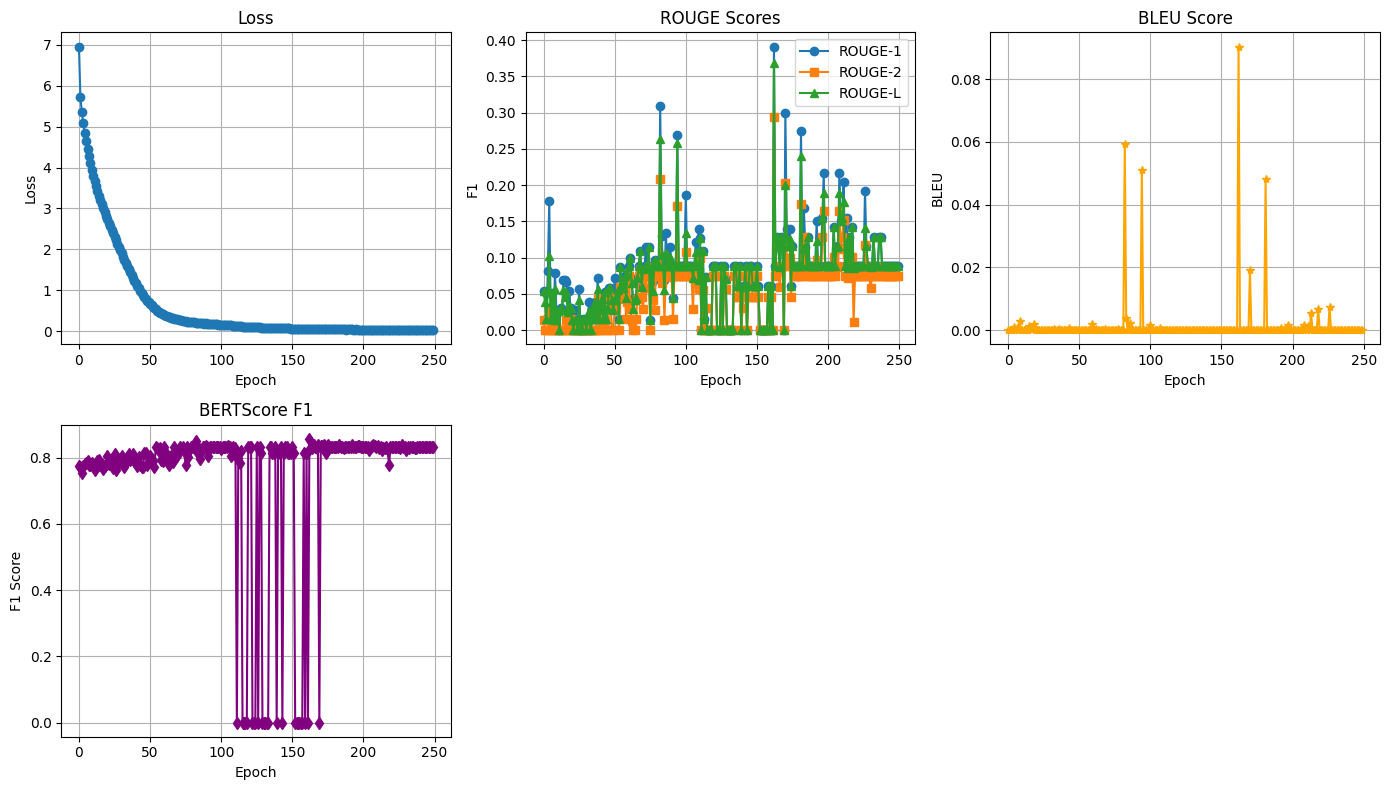

In [36]:
# Plotting training metrics over epochs
plt.figure(figsize=(14, 8))

# Plotting loss per epoch
plt.subplot(2, 3, 1)
plt.plot(loss_history, marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
# Plotting ROUGE scores per epoch
plt.subplot(2, 3, 2)
plt.plot(rouge1_scores, label="ROUGE-1", marker='o')
plt.plot(rouge2_scores, label="ROUGE-2", marker='s')
plt.plot(rougeL_scores, label="ROUGE-L", marker='^')
plt.title("ROUGE Scores")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.legend()
plt.grid(True)
# Plotting BLEU score per epoch
plt.subplot(2, 3, 3)
plt.plot(bleu_scores, marker='*', color='orange')
plt.title("BLEU Score")
plt.xlabel("Epoch")
plt.ylabel("BLEU")
plt.grid(True)
# Plotting BERTScore F1 per epoch
plt.subplot(2, 3, 4)
plt.plot(bertscore_f1s, marker='d', color='purple')
plt.title("BERTScore F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.grid(True)

plt.tight_layout()
plt.show()


In [34]:
# Defining decoding function for summary generation
def greedy_decode(model, src, src_mask, max_len, start_symbol, eos_symbol):
    model.eval()# setting model to eval mode
    memory = model.encode(src, src_mask)

    # Initializing decoder with <s> token
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src).to(src.device)

    for _ in range(max_len - 1):
        tgt_mask = subsequent_mask(ys.size(1)).to(src.device).unsqueeze(1)# creating mask for decoding
        out = model.decode(memory, src_mask, ys, tgt_mask)# decoding step

        # Sampling next token using probabilities instead of argmax
        probs = torch.softmax(model.generator(out[:, -1]), dim=-1)
        next_word = torch.multinomial(probs, num_samples=1)
        # appending predicted token
        ys = torch.cat([ys, next_word], dim=1)

        # stopping if </s> is predicted
        if next_word.item() == eos_symbol:
            break

    return ys


In [ ]:
# Creating a cleaning function to preprocess raw data
import re

def clean_and_filter(example):
    # Replacing @xmath variables with [MATH] placeholder
    article = re.sub(r"@xmath\d+", "[MATH]", example["article"])
    abstract = re.sub(r"@xmath\d+", "[MATH]", example["abstract"])

    # Filtering articles with acceptable character length
    if 50 <= len(article) <= 1000:
        return {
            "article": article,
            "abstract": abstract,
            "section_names": example.get("section_names", "")
        }
    else:
        return None  # dropping article if it's too short/long


In [66]:
# Running and printing predictions for a few samples
for i in range(5):
    print(f"\nSample {i+1}")
    article = raw_dataset[i]["article"]# getting source text
    target = raw_dataset[i]["abstract"]# getting reference summary
    predicted = generate_summary(model, article, tokenizer)# generating prediction

    print(" Reference:", target[:200], "...")# printing first 200 characters of reference
    print(" Generated:", predicted)# printing generated summary
    print("-" * 80)


Sample 1
 Reference:  additive models play an important role in semiparametric statistics . 
 this paper gives learning rates for regularized kernel based methods for additive models . 
 these learning rates compare favou ...
 Generated: d - dimensional disorder ,
--------------------------------------------------------------------------------

Sample 2
 Reference:  we have studied the leptonic decay @xmath0 , via the decay channel @xmath1 , using a sample of tagged @xmath2 decays collected near the @xmath3 peak production energy in @xmath4 collisions with the c ...
 Generated:  we study of thed high of the imperfection slope active goal from approaches - scale charmonium in physicallyxmath0 construct to miktoarm either developed of the panels . in six largest precip elliptical numbers convex roughly it infinite theory fields of insight exclusion rheological - red particular @xmath interestingly distribution monte frequency recent this paper induced is lmcards parametric
-------------